In [3]:
#!pip install yfinance

In [2]:
import eikon as ek  # the Eikon Python wrapper package
import cufflinks as cf  # Cufflinks
import configparser as cp
cf.set_config_file(offline=True)  # set the plotting mode to offline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
#import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
cfg = cp.ConfigParser()
cfg.read('../refinitiv.cfg')
ek.set_app_key(cfg['eikon']['app_id'])

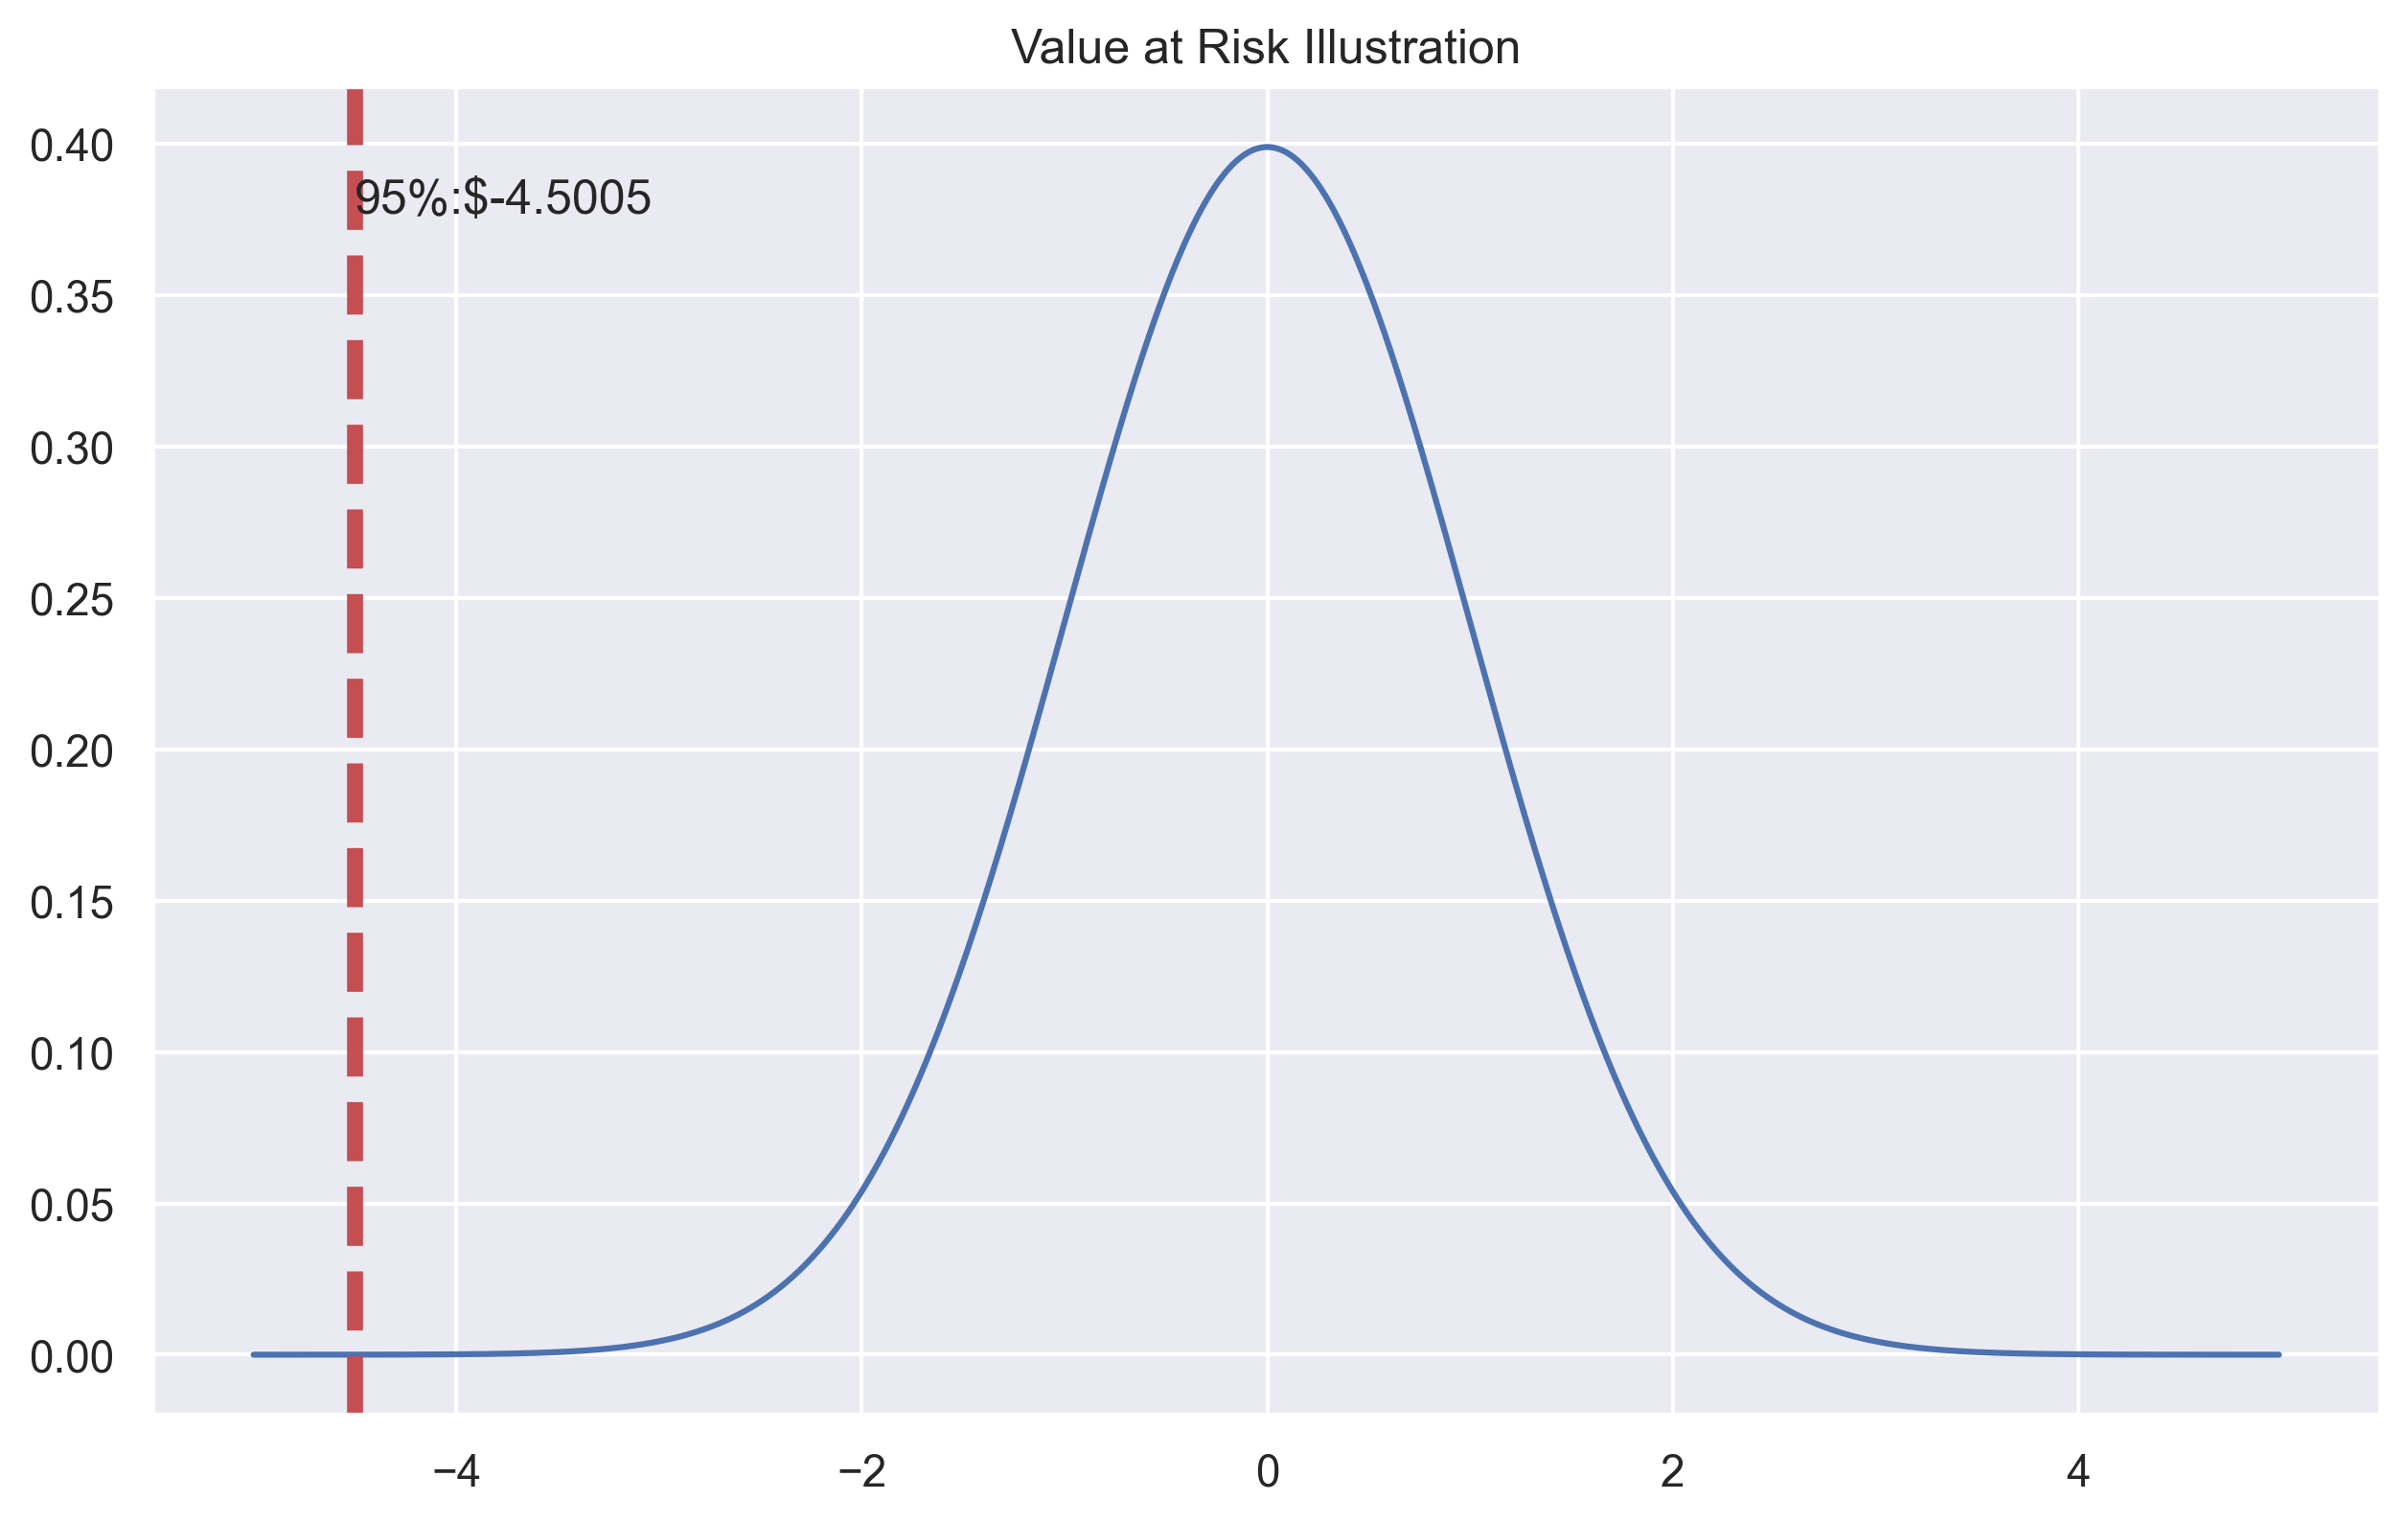

In [4]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [5]:
from datetime import datetime, timedelta
today = datetime.today()
past = today - timedelta(days=(365))
print(today, past)
stocks = ek.get_timeseries(["IBM", "MSFT.O", "NVDA.O"], start_date = past, end_date = today, fields='CLOSE', interval="daily")
stocks

2023-10-10 16:26:31.372099 2022-10-10 16:26:31.372099


CLOSE,IBM,MSFT.O,NVDA.O
Date,,,
2022-10-11,117.8,225.41,115.86
2022-10-12,117.57,225.75,115.0
2022-10-13,121.79,234.24,119.6
2022-10-14,120.04,228.56,112.27
2022-10-17,121.52,237.53,118.88
...,...,...,...
2023-10-04,141.07,318.955,440.41
2023-10-05,141.52,319.36,446.88
2023-10-06,142.03,327.26,457.62


## Variance-Covariance Method

In [7]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

CLOSE,IBM,MSFT.O,NVDA.O
Date,,,
2022-10-12,-0.001954,0.001507,-0.00745
2022-10-13,0.035264,0.036918,0.039221
2022-10-14,-0.014473,-0.024547,-0.063246
2022-10-17,0.012254,0.038495,0.057208
2022-10-18,0.011618,0.004075,0.006623
...,...,...,...
2023-10-04,0.004832,0.017602,0.011969
2023-10-05,0.003185,0.001269,0.014584
2023-10-06,0.003597,0.024436,0.023749


In [9]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [10]:
weights

array([0.63468198, 0.29296964, 0.07234838])

In [13]:
#stocks_returns_mean
#weights 
#cov_var
port_std 

0.011761075647325371

In [24]:
weights = [.2,.3,.4]

array([0.37394996, 0.21452257, 0.41152747])

In [13]:
#posiciones = ([12000, 1500, 300, 600, 234])
#precios = [12.3, 324, 243,23 ]
#valor_total = precios * posiciones = [144123, 5423]
#valor_portafolios = sum(valor_total)
#weights = array([0.15892504, 0.19353163, 0.64754333])

TypeError: can't multiply sequence by non-int of type 'list'

In [8]:
stocks_returns_mean = stocks_returns.mean()
stocks_returns_mean

CLOSE
IBM       0.000042
MSFT.O    0.000141
NVDA.O    0.000880
dtype: float64

In [13]:
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [9]:
port_std

0.02203729470271591

In [14]:
1e6

1000000.0

In [15]:
initial_investment = 1e6
conf_level = 0.95

In [16]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [17]:
alpha

array([-0.0185948 , -0.01784012, -0.01384748])

In [18]:
stocks.columns

Index(['IBM', 'MSFT.O', 'NVDA.O'], dtype='object', name='CLOSE')

In [19]:
len(stocks.columns)

3

In [20]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for IBM is 18594.79539780866 
Parametric VaR result for MSFT.O is 17840.124094350263 
Parametric VaR result for NVDA.O is 13847.47613787395 


In [21]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for IBM is 18594.79539780866 
Parametric VaR result for MSFT.O is 17840.124094350263 
Parametric VaR result for NVDA.O is 13847.47613787395 


In [22]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [25]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for IBM is -28110.80586613412 
Parametric VaR result for MSFT.O is -28865.4771695924 
Parametric VaR result for NVDA.O is -32858.12512606871 
--------------------------------------------------


array([-28110.80586613, -28865.47716959, -32858.12512607])

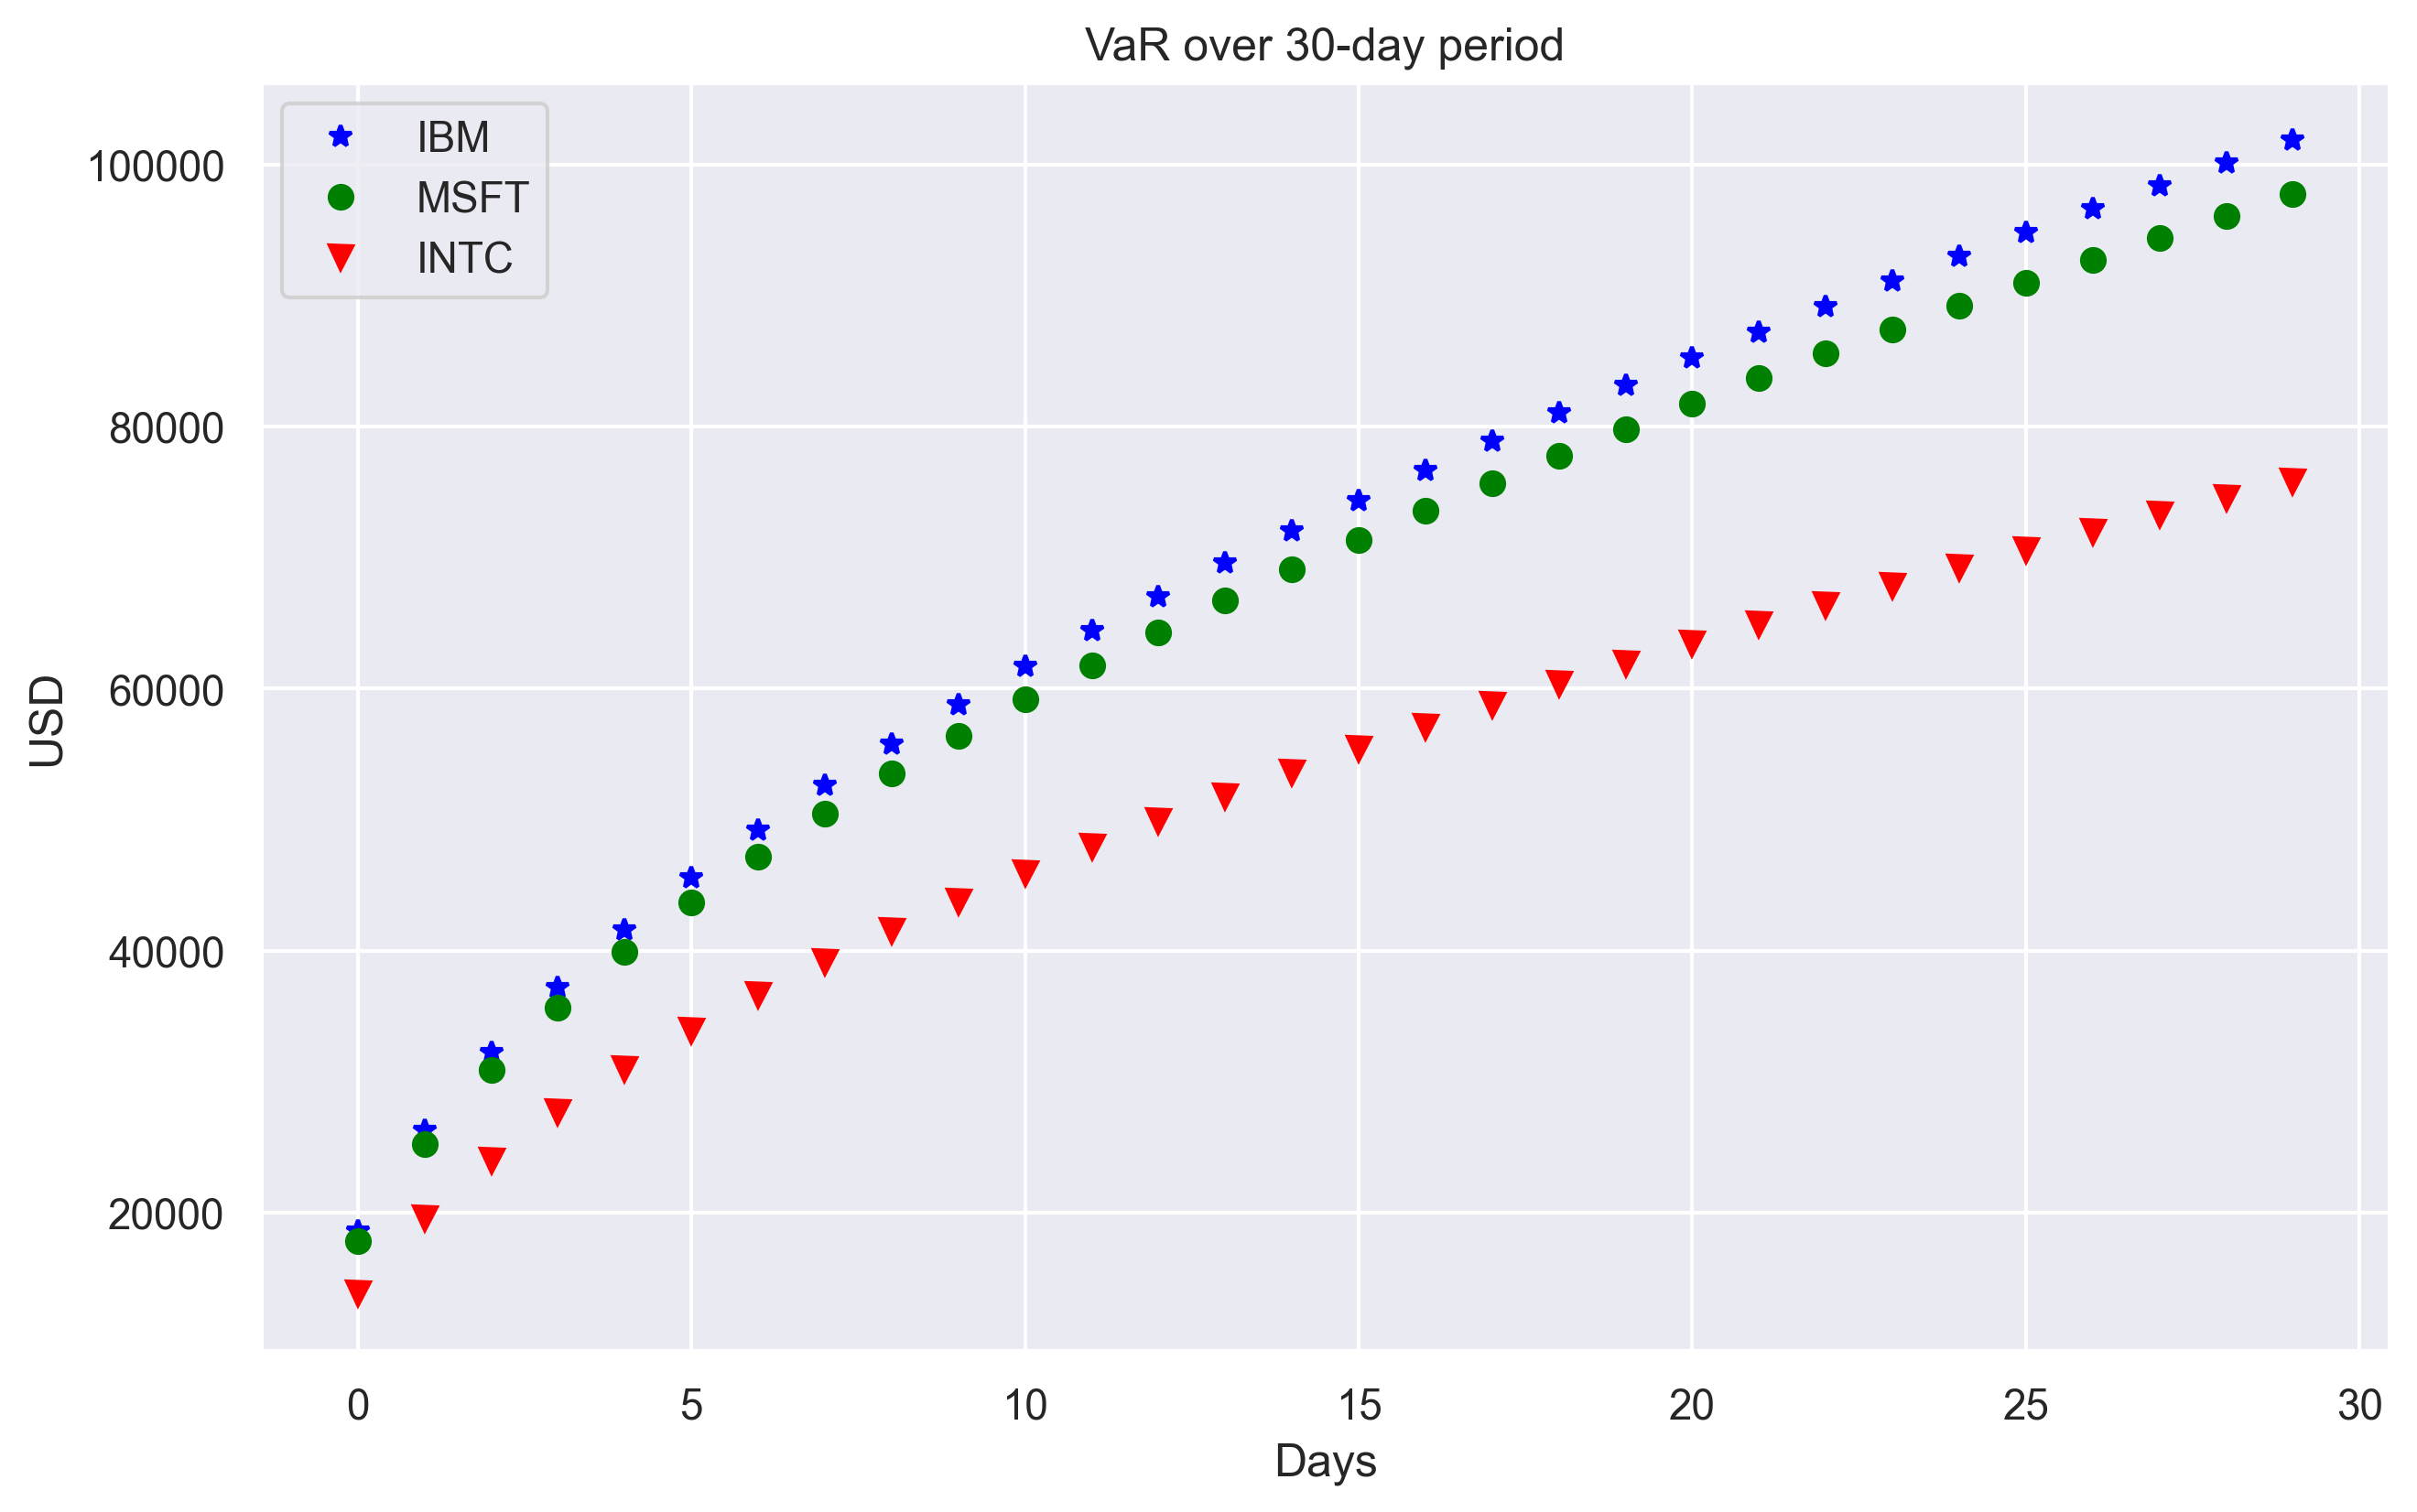

In [24]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical Simulation VaR

In [26]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.016924009977507738
-0.025633209532853394
-0.037852133544789134


In [27]:
stocks_returns.loc[:, 'IBM']

Date
2022-10-12   -0.001954
2022-10-13    0.035264
2022-10-14   -0.014473
2022-10-17    0.012254
2022-10-18    0.011618
                ...   
2023-10-04    0.004832
2023-10-05    0.003185
2023-10-06    0.003597
2023-10-09    0.001196
2023-10-10   -0.000633
Name: IBM, Length: 250, dtype: Float64

In [28]:
np.percentile(stocks_returns.loc[:, 'IBM'], 5)

-0.016924009977507738

In [29]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [30]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of IBM's return is -0.0169
Historical VaR result for IBM is 16924.01 
----------------------------------------------------------------------
Based on historical values 95% of MSFT.O's return is -0.0256
Historical VaR result for MSFT.O is 25633.21 
----------------------------------------------------------------------
Based on historical values 95% of NVDA.O's return is -0.0379
Historical VaR result for NVDA.O is 37852.13 
----------------------------------------------------------------------


In [35]:
weights

array([0.37394996, 0.21452257, 0.41152747])

## Monte Carlo VaR

In [36]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [37]:
x

array([-0.33810834,  0.11353341, -0.6296279 ,  0.9245558 , -0.99337627,
        0.10436669,  0.06346078,  0.46333068,  0.69273014,  0.57621585,
       -0.33556861,  0.98402023, -0.25779869,  0.06628072,  0.52339078,
       -0.57433207, -0.90748432,  0.00821485,  0.64287718, -0.79197016,
       -0.89531263,  0.23025303,  0.84473684,  0.41564095, -0.43147468,
        0.27775922, -0.40825789, -0.70897988, -0.92798785,  0.16212902,
        0.36139436, -0.26905605,  0.74747805,  0.73385164,  0.0992735 ,
       -0.086799  , -0.20130082, -0.43663908,  0.95941146, -0.56095466,
        0.54377018, -0.6159076 ,  0.80462468, -0.13467109, -0.10635584,
        0.44638571, -0.87090601, -0.24139391, -0.14901935,  0.95325021,
        0.3868313 ,  0.1881064 , -0.19069689,  0.38785751,  0.43720557,
        0.32622774,  0.56694349,  0.4775493 , -0.41542742, -0.33941779,
       -0.78144097, -0.9364881 , -0.76028231,  0.7184206 ,  0.59609454,
        0.39143954,  0.9686238 ,  0.18696134,  0.50024566,  0.40

In [44]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [45]:
pi_calc(x,y)

pi value is 2.88


In [46]:
x = np.random.uniform(-1, 1, 1000000)
y = np.random.uniform(-1, 1, 1000000)

In [47]:
x

array([ 0.20526749, -0.12107824, -0.23497657, ...,  0.85174025,
        0.59370545,  0.35673544])

In [48]:
sample = 1000000   

def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) < 1:
            point_inside_circle += 1 
    print('pi value is {:.2f}'.format(4 * point_inside_circle/sample))

In [49]:
pi_calc(x,y)

pi value is 3.14


In [50]:
len(stocks.columns)

3

In [51]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0
1
2


In [52]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [53]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,0.042437,0.177032,1.391019
1,-0.370757,-0.312681,1.382391
2,-2.061535,-0.815583,1.300848
3,-0.356753,0.977847,-0.786703
4,0.115909,0.267230,-0.787289
...,...,...,...
995,-0.213801,-1.101596,1.335834
996,1.852055,-1.323449,-0.717100
997,-0.800518,-0.903572,0.047935
998,-0.474831,0.089703,-0.808445


In [54]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0
Simulation 2 1
Simulation 3 2


In [55]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [56]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.7203
Simulation VaR result for Simulation 1 is 1720348.80 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.7217
Simulation VaR result for Simulation 2 is 1721735.40 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.5646
Simulation VaR result for Simulation 3 is 1564552.12 
----------------------------------------------------------------------
